In [1]:
%load_ext autoreload
%autoreload 2
from renyi import renyi_sim_entropy, rbf_kernel
from sklearn.neighbors import NearestNeighbors
from utils import batch_pdist
import utils
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as ss
from umap import UMAP

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
matplotlib.rcParams.update({'font.size': 18})

In [2]:
from gan_entropy_eval.readers.mnist import MNISTReader

In [119]:
def rbf_kernel(X, Y, sigmas=[1.], p=2, degree=2):
    pdist = utils.batch_pdist(X, Y, p)
    res = torch.zeros_like(pdist)
    for sigma in sigmas:
        res += torch.exp(- (pdist/sigma)**degree)
    return res / len(sigmas)

def rbf_kernel_pdist(pdist, sigmas=[1.], p=2, degree=2):
    res = torch.zeros_like(pdist)
    for sigma in sigmas:
        res += torch.exp(- (pdist/sigma)**degree)
    return res / len(sigmas)

def batch_pdist(X, Y, p=2):
    return torch.norm(X[..., None, :] - Y[..., None, :, :], p=p, dim=-1)

def birthday(dists, eps=1.):
    """
    Take in a set of distances and a ball radius and estimate the size of the support.
    We use the fact that in a perfect case of drawing m samples with replacement from a uniform discrete
    distribution of support n the expected number of collisions is c = (m^2 - m)/n, so we can estimate n as
    \hat(n) = (m^2 - m)/c.
    
    This approach is dramatically faster than the traditional birthday paradox approach, which is to estimate the
    batch size required to have a 50% chance of a collision; that approach makes sense when human input is required,
    but it does not when comparisons are automatic and counting the number of collisions is trivial
    """
    dists = dists + 10*eps*torch.eye(dists.shape[0], device=dists.device) # Mask the diagonal
    collisions = (dists < eps)
    collisions = collisions.float().sum()
    if collisions < 1:
        collisions = collisions + 1
    count = (dists.shape[0] **2 - dists.shape[0])/collisions
    return count.item()
    

In [4]:
reader = MNISTReader("./data")

In [11]:
iterator = reader.iter_batches("train", 100000, partial_batching=True)
data = []
for batch in iterator:
    data.append(batch)
labels = data[0][1]
data = data[0][0]
flat_data = data.flatten(1, -1).numpy()

In [12]:
reducer = UMAP(n_components=2, min_dist=0.001, metric="cosine")
umap_data = reducer.fit_transform(flat_data[:])

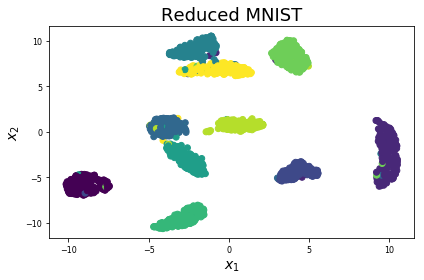

In [13]:
plt.figure()
plt.scatter(umap_data[:2000, 0], umap_data[:2000, 1], c=labels[:2000])
plt.title("Reduced MNIST")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.tight_layout()
plt.savefig("reduced_mnist.pdf")
plt.show()

In [14]:
umap_data = torch.tensor(umap_data)

In [16]:
pdists = batch_pdist(umap_data[:1000], umap_data[:1000], 2)
raw_pdists = batch_pdist(torch.tensor(flat_data[:1000]), torch.tensor(flat_data[:1000]), 1)

In [128]:
sigmas = np.linspace(1, 10, 100)
entropies = []
alpha = 1
for j, sigma in enumerate(sigmas):
    k = rbf_kernel_pdist(pdists, sigmas=[sigma], degree=2)
    entropy = renyi_sim_entropy(k, torch.ones(k.shape[0])/k.shape[0], alpha=alpha).item()
    entropies.append(entropy)

In [120]:
eps = np.linspace(1., 10, 100)
counts = []
alpha = 1
for j, sigma in enumerate(eps):
#     k = rbf_kernel_pdist(pdists, sigmas=[sigma], degree=2)
    count = birthday(pdists, eps=sigma)
    counts.append(count)

### Plotting

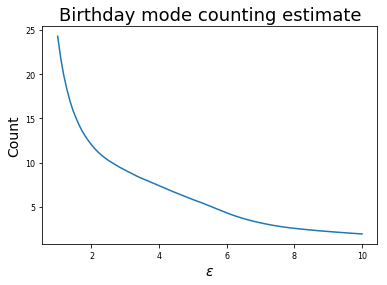

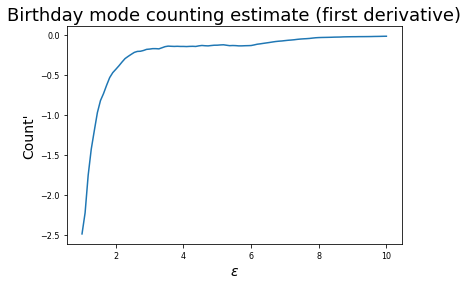

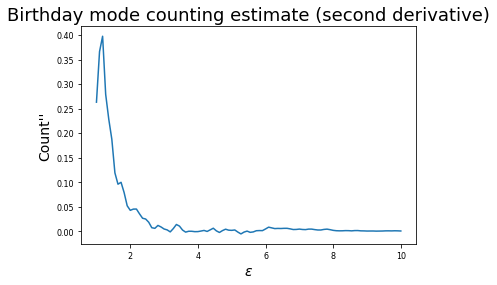

In [124]:
plt.figure()
plt.plot(eps, counts, label="Birthday Estimate")
# plt.yscale("log")
plt.title("Birthday mode counting estimate")
plt.xlabel(r"$\epsilon$")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.plot(eps, np.gradient(counts), label="Birthday Estimate")
# plt.yscale("log")
plt.title("Birthday mode counting estimate (first derivative)")
plt.xlabel(r"$\epsilon$")
plt.ylabel("Count\'")
plt.show()

plt.figure()
plt.plot(eps, np.gradient(np.gradient(counts)), label="Birthday Estimate")
# plt.yscale("log")
plt.title("Birthday mode counting estimate (second derivative)")
plt.xlabel(r"$\epsilon$")
plt.ylabel("Count\'\'")
plt.show()

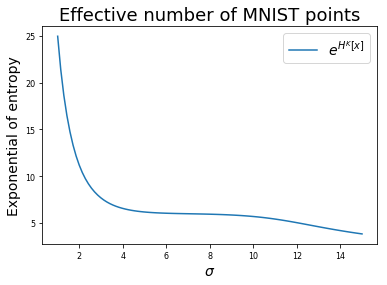

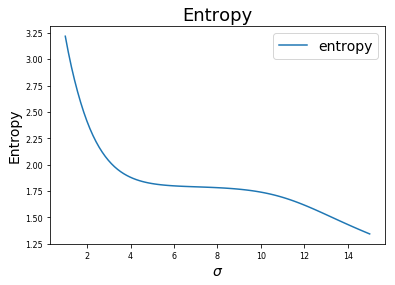

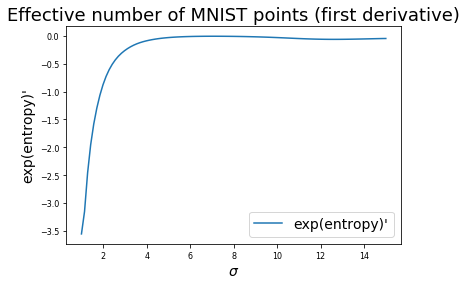

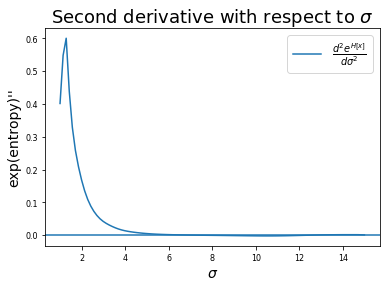

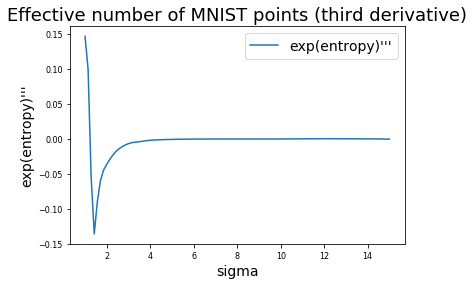

In [126]:
plt.figure()
plt.plot(sigmas, np.exp(entropies), label=r"$e^{H^K[x]}$")
plt.xlabel(r"$\sigma$")
plt.ylabel("Exponential of entropy")
# plt.axhline(10)
plt.legend()
plt.title("Effective number of MNIST points")
# plt.xlim(10, 20)
# plt.ylim(0, 4)
plt.show()

plt.figure()
plt.plot(sigmas, entropies, label="entropy")
plt.xlabel(r"$\sigma$")
plt.ylabel("Entropy")
plt.legend()
plt.title("Entropy")
# plt.xlim(10, 20)
# plt.ylim(0, 4)
plt.show()

plt.figure()
plt.plot(sigmas, np.gradient((np.exp(entropies))), label="exp(entropy)\'")
plt.xlabel(r"$\sigma$")
plt.ylabel("exp(entropy)\'")
plt.title("Effective number of MNIST points (first derivative)")
plt.legend()
# plt.xlim(10, 20)
# plt.ylim(0, 4)
plt.show()


plt.figure()
plt.plot(sigmas, np.gradient(np.gradient(np.exp(entropies))), label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$")
plt.xlabel(r"$\sigma$")
plt.axhline(0)
plt.ylabel("exp(entropy)\'\'")
plt.title(r"Second derivative with respect to $\sigma$")
plt.legend()
# plt.xlim(10, 20)
# plt.ylim(0, 4)
plt.show()



plt.figure()
plt.plot(sigmas, np.gradient(np.gradient(np.gradient(np.exp(entropies)))), label="exp(entropy)\'\'\'")
plt.xlabel("sigma")
plt.ylabel("exp(entropy)\'\'\'")
plt.title("Effective number of MNIST points (third derivative)")
plt.legend()
# plt.xlim(10, 20)
# plt.ylim(0, 4)
plt.show()

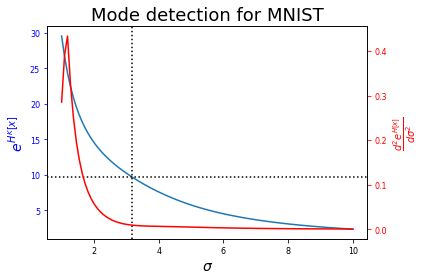

In [130]:
first_below_thresh = np.arange(len(entropies))[np.gradient(np.gradient(np.exp(entropies))) < 0.01][0]
vertical = sigmas[first_below_thresh]
estimated_count = np.exp(entropies)[first_below_thresh]

fig, ax1 = plt.subplots()
# t = np.arange(0.01, 10.0, 0.01)
# s1 = np.exp(t)
ax1.plot(sigmas, np.exp(entropies), label=r"$e^{H^K[x]}$")
ax1.set_xlabel(r'$\sigma$')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r"$e^{H^K[x]}$", color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
# s2 = np.sin(2 * np.pi * t)
ax2.plot(sigmas, np.gradient(np.gradient(np.exp(entropies))), label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", c="r")
ax2.set_ylabel(r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", color='r',)
ax2.tick_params('y', colors='r')

ax1.axhline(estimated_count, color="k", linestyle=":")
ax1.axvline(vertical, color="k", linestyle=":")
# ax2.axhline(0.01, color="k", linestyle=":")
plt.title("Mode detection for MNIST")
fig.tight_layout()
plt.savefig("mnist_detection.pdf")
plt.show()

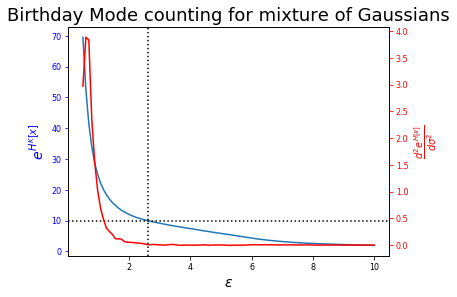

In [116]:
first_below_thresh = np.arange(len(counts))[np.gradient(np.gradient(counts)) < 0.01][0]
vertical = eps[first_below_thresh]
estimated_count = counts[first_below_thresh]

fig, ax1 = plt.subplots()
# t = np.arange(0.01, 10.0, 0.01)
# s1 = np.exp(t)
ax1.plot(eps, counts, label=r"$e^{H^K[x]}$")
ax1.set_xlabel(r'$\epsilon$')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r"$e^{H^K[x]}$", color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
# s2 = np.sin(2 * np.pi * t)
ax2.plot(eps, np.gradient(np.gradient(counts)), label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", c="r")
ax2.set_ylabel(r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", color='r',)
ax2.tick_params('y', colors='r')

ax1.axhline(estimated_count, color="k", linestyle=":")
ax1.axvline(vertical, color="k", linestyle=":")
# ax2.axhline(0.01, color="k", linestyle=":")
fig.tight_layout()
plt.title("Birthday Mode counting for mixture of Gaussians")
plt.savefig("mog_detection.pdf")
plt.show()

## Mixture of Gaussians

In [85]:
n = 1000
# Parameters of the mixture components
norm_means = np.array([[5, 1],
                        [-1, -5],
                        [-9, 3],
                        [25, 18],
                        [-10, 15],
                        [15, -9]])

norm_covs = [1*np.eye(2) for i in range(norm_means.shape[0])]
n_components = norm_means.shape[0]
# Weight of each component, in this case all of them are 1/3
weights = np.ones(len(norm_means), dtype=np.float64) / len(norm_means)
# A stream of indices from which to choose the component
mixture_idx = np.random.choice(len(weights), size=n, replace=True, p=weights)
# y is the mixture sample
data = np.stack([np.random.multivariate_normal(norm_means[i], norm_covs[i]) for i in mixture_idx], 0)


In [86]:
gmm_pdists = utils.batch_pdist(torch.tensor(data), torch.tensor(data), 1).float()

In [87]:
sigmas = np.linspace(1.5, 15, 100)
# sigmas = np.exp(ks)
entropies = []
for sigma in sigmas:
    k = rbf_kernel_pdist(gmm_pdists, sigmas=[sigma], degree=10)
#     k = 1 / (1 + pdists/sigma)**2
    entropy = renyi_sim_entropy(k, torch.ones(k.shape[0])/k.shape[0]).item()
    entropies.append(entropy)

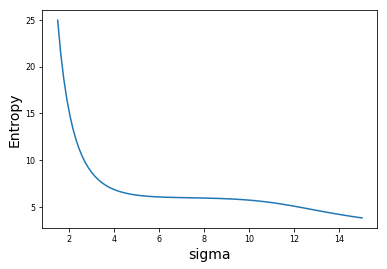

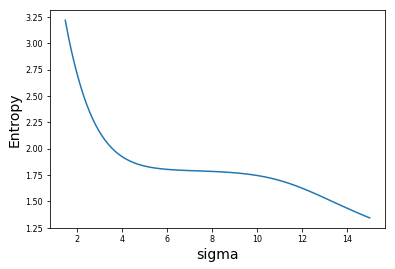

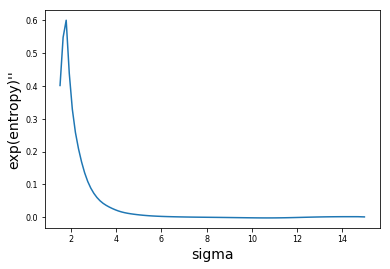

In [88]:
plt.figure()
plt.plot(sigmas, np.exp(entropies))
plt.xlabel("sigma")
plt.ylabel("Entropy")
plt.show()

plt.figure()
plt.plot(sigmas, (entropies))
plt.xlabel("sigma")
plt.ylabel("Entropy")
plt.show()


plt.figure()
plt.plot(sigmas, np.gradient(np.gradient(np.exp(entropies))))
plt.xlabel("sigma")
plt.ylabel("exp(entropy)\'\'")
plt.show()

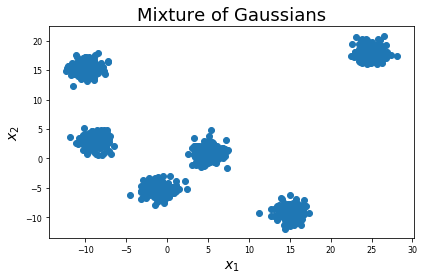

In [89]:
plt.figure()
plt.scatter(data[:, 0], data[:, 1])
plt.title("Mixture of Gaussians")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.tight_layout()
plt.savefig("mixture.pdf")
plt.show()

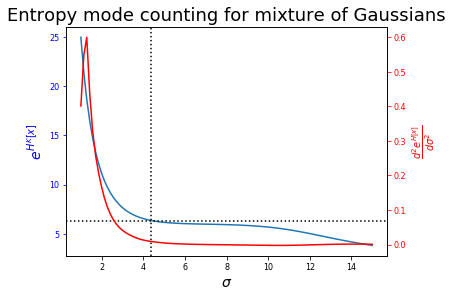

In [113]:
first_below_thresh = np.arange(len(entropies))[np.gradient(np.gradient(np.exp(entropies))) < 0.01][0]
vertical = sigmas[first_below_thresh]
estimated_count = np.exp(entropies)[first_below_thresh]

fig, ax1 = plt.subplots()
# t = np.arange(0.01, 10.0, 0.01)
# s1 = np.exp(t)
ax1.plot(sigmas, np.exp(entropies), label=r"$e^{H^K[x]}$")
ax1.set_xlabel(r'$\sigma$')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r"$e^{H^K[x]}$", color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
# s2 = np.sin(2 * np.pi * t)
ax2.plot(sigmas, np.gradient(np.gradient(np.exp(entropies))), label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", c="r")
ax2.set_ylabel(r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", color='r',)
ax2.tick_params('y', colors='r')

ax1.axhline(estimated_count, color="k", linestyle=":")
ax1.axvline(vertical, color="k", linestyle=":")
# ax2.axhline(0.01, color="k", linestyle=":")
fig.tight_layout()
plt.title("Entropy mode counting for mixture of Gaussians")
plt.savefig("mog_detection.pdf")
plt.show()

In [108]:
eps = np.linspace(1, 15, 100)
gmm_counts = []
alpha = 1
for j, cutoff in enumerate(eps):
#     k = rbf_kernel_pdist(pdists, sigmas=[sigma], degree=2)
    gmm_count = birthday(gmm_pdists, eps=cutoff)
    print(gmm_count)
    gmm_counts.append(gmm_count)

39.93124771118164
31.340192794799805
25.591760635375977
21.417545318603516
18.346433639526367
15.990653038024902
14.198408126831055
12.785072326660156
11.626282691955566
10.685863494873047
9.904032707214355
9.286458015441895
8.76392650604248
8.32236385345459
7.9653639793396
7.647554397583008
7.389381408691406
7.170233726501465
6.9844512939453125
6.825169086456299
6.688358783721924
6.575050354003906
6.4844865798950195
6.405981540679932
6.342132568359375
6.283176898956299
6.23222017288208
6.18744421005249
6.151856422424316
6.125527381896973
6.10188102722168
6.082784652709961
6.0667524337768555
6.053297996520996
6.041875839233398
6.032827377319336
6.024895668029785
6.017709732055664
6.011481285095215
6.005988121032715
6.001297473907471
5.997766971588135
5.993880271911621
5.989280700683594
5.985907077789307
5.981247901916504
5.976953983306885
5.971237659454346
5.965033531188965
5.958061218261719
5.949403285980225
5.940558433532715
5.929839134216309
5.917545318603516
5.905791282653809
5.891

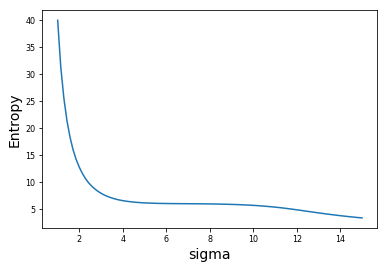

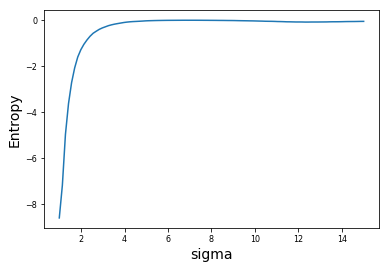

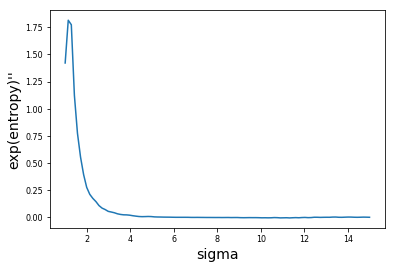

In [105]:
plt.figure()
plt.plot(sigmas, gmm_counts)
plt.xlabel("sigma")
plt.ylabel("Entropy")
plt.show()

plt.figure()
plt.plot(sigmas, np.gradient(gmm_counts))
plt.xlabel("sigma")
plt.ylabel("Entropy")
plt.show()


plt.figure()
plt.plot(sigmas, np.gradient(np.gradient(gmm_counts)))
plt.xlabel("sigma")
plt.ylabel("exp(entropy)\'\'")
plt.show()

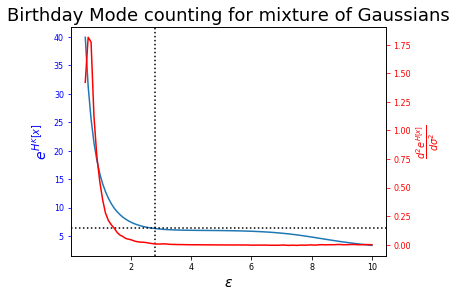

In [117]:
first_below_thresh = np.arange(len(entropies))[np.gradient(np.gradient(gmm_counts)) < 0.01][0]
vertical = eps[first_below_thresh]
estimated_count = gmm_counts[first_below_thresh]

fig, ax1 = plt.subplots()
# t = np.arange(0.01, 10.0, 0.01)
# s1 = np.exp(t)
ax1.plot(eps, gmm_counts, label=r"$e^{H^K[x]}$")
ax1.set_xlabel(r'$\epsilon$')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r"$e^{H^K[x]}$", color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
# s2 = np.sin(2 * np.pi * t)
ax2.plot(eps, np.gradient(np.gradient(gmm_counts)), label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", c="r")
ax2.set_ylabel(r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", color='r',)
ax2.tick_params('y', colors='r')

ax1.axhline(estimated_count, color="k", linestyle=":")
ax1.axvline(vertical, color="k", linestyle=":")
# ax2.axhline(0.01, color="k", linestyle=":")
fig.tight_layout()
plt.title("Birthday Mode counting for mixture of Gaussians")
plt.savefig("mog_detection.pdf")
plt.show()